# Example of usage Spark OCR with http source

## Install spark-ocr python packge
Need specify path to `spark-ocr-assembly-[version].jar` or `secret`

In [9]:
secret = ""
license = ""
version = secret.split("-")[0]
spark_ocr_jar_path = "../../target/scala-2.11"

In [ ]:
%%bash
if python -c 'import google.colab' &> /dev/null; then
    echo "Run on Google Colab!"
    echo "Install Open JDK"
    apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
    java -version
fi

In [ ]:
import sys
import os

if 'google.colab' in sys.modules:
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
  os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

In [ ]:
# install from PYPI using secret
%pip install spark-ocr==$version --user --extra-index-url=https://pypi.johnsnowlabs.com/$secret --upgrade
%pip install requests --user

In [ ]:
# or install from local path
# %pip install --user ../dist/spark-ocr-[version].tar.gz

## Initialization of spark session

In [10]:
from pyspark.sql import SparkSession
from sparkocr import start

if license:
    os.environ['JSL_OCR_LICENSE'] = license

spark = start(secret=secret, jar_path=spark_ocr_jar_path)
spark

SparkConf Configured, Starting to listen on port: 60321
JAR PATH:/usr/local/lib/python3.7/site-packages/sparkmonitor/listener.jar


## Import OCR transformers

In [50]:
import requests
import io
from sparkocr.transformers import *
from sparkocr.utils import display_image
from pyspark.ml import PipelineModel

# Example with PDF
## Define OCR transformers and pipeline

In [54]:
def pipeline():
    
    # Transforrm PDF document to images per page
    pdf_to_image = PdfToImage()
    pdf_to_image.setInputCol("content")
    pdf_to_image.setOutputCol("image")

    # Run OCR
    ocr = ImageToText()
    ocr.setInputCol("image")
    ocr.setOutputCol("text")
    ocr.setConfidenceThreshold(65)
    
    pipeline = PipelineModel(stages=[
        pdf_to_image,
        ocr
    ])
    
    return pipeline

## Read PDF document by url

In [55]:
url = 'http://www.asx.com.au/asxpdf/20171103/pdf/43nyyw9r820c6r.pdf'
response = requests.get(url)
my_raw_data = response.content
pdf_content = io.BytesIO(my_raw_data)
pdf_example_df = spark.createDataFrame([("file1", bytearray(my_raw_data)),], ("path", "content"))
pdf_example_df.show()

+-----+--------------------+
| path|             content|
+-----+--------------------+
|file1|[25 50 44 46 2D 3...|
+-----+--------------------+



## Run OCR pipeline

In [56]:
result = pipeline().transform(pdf_example_df).cache()

## Display Original document

Image:
        origin: file1 
        width: 2479
        height: 3508
        mode: 10


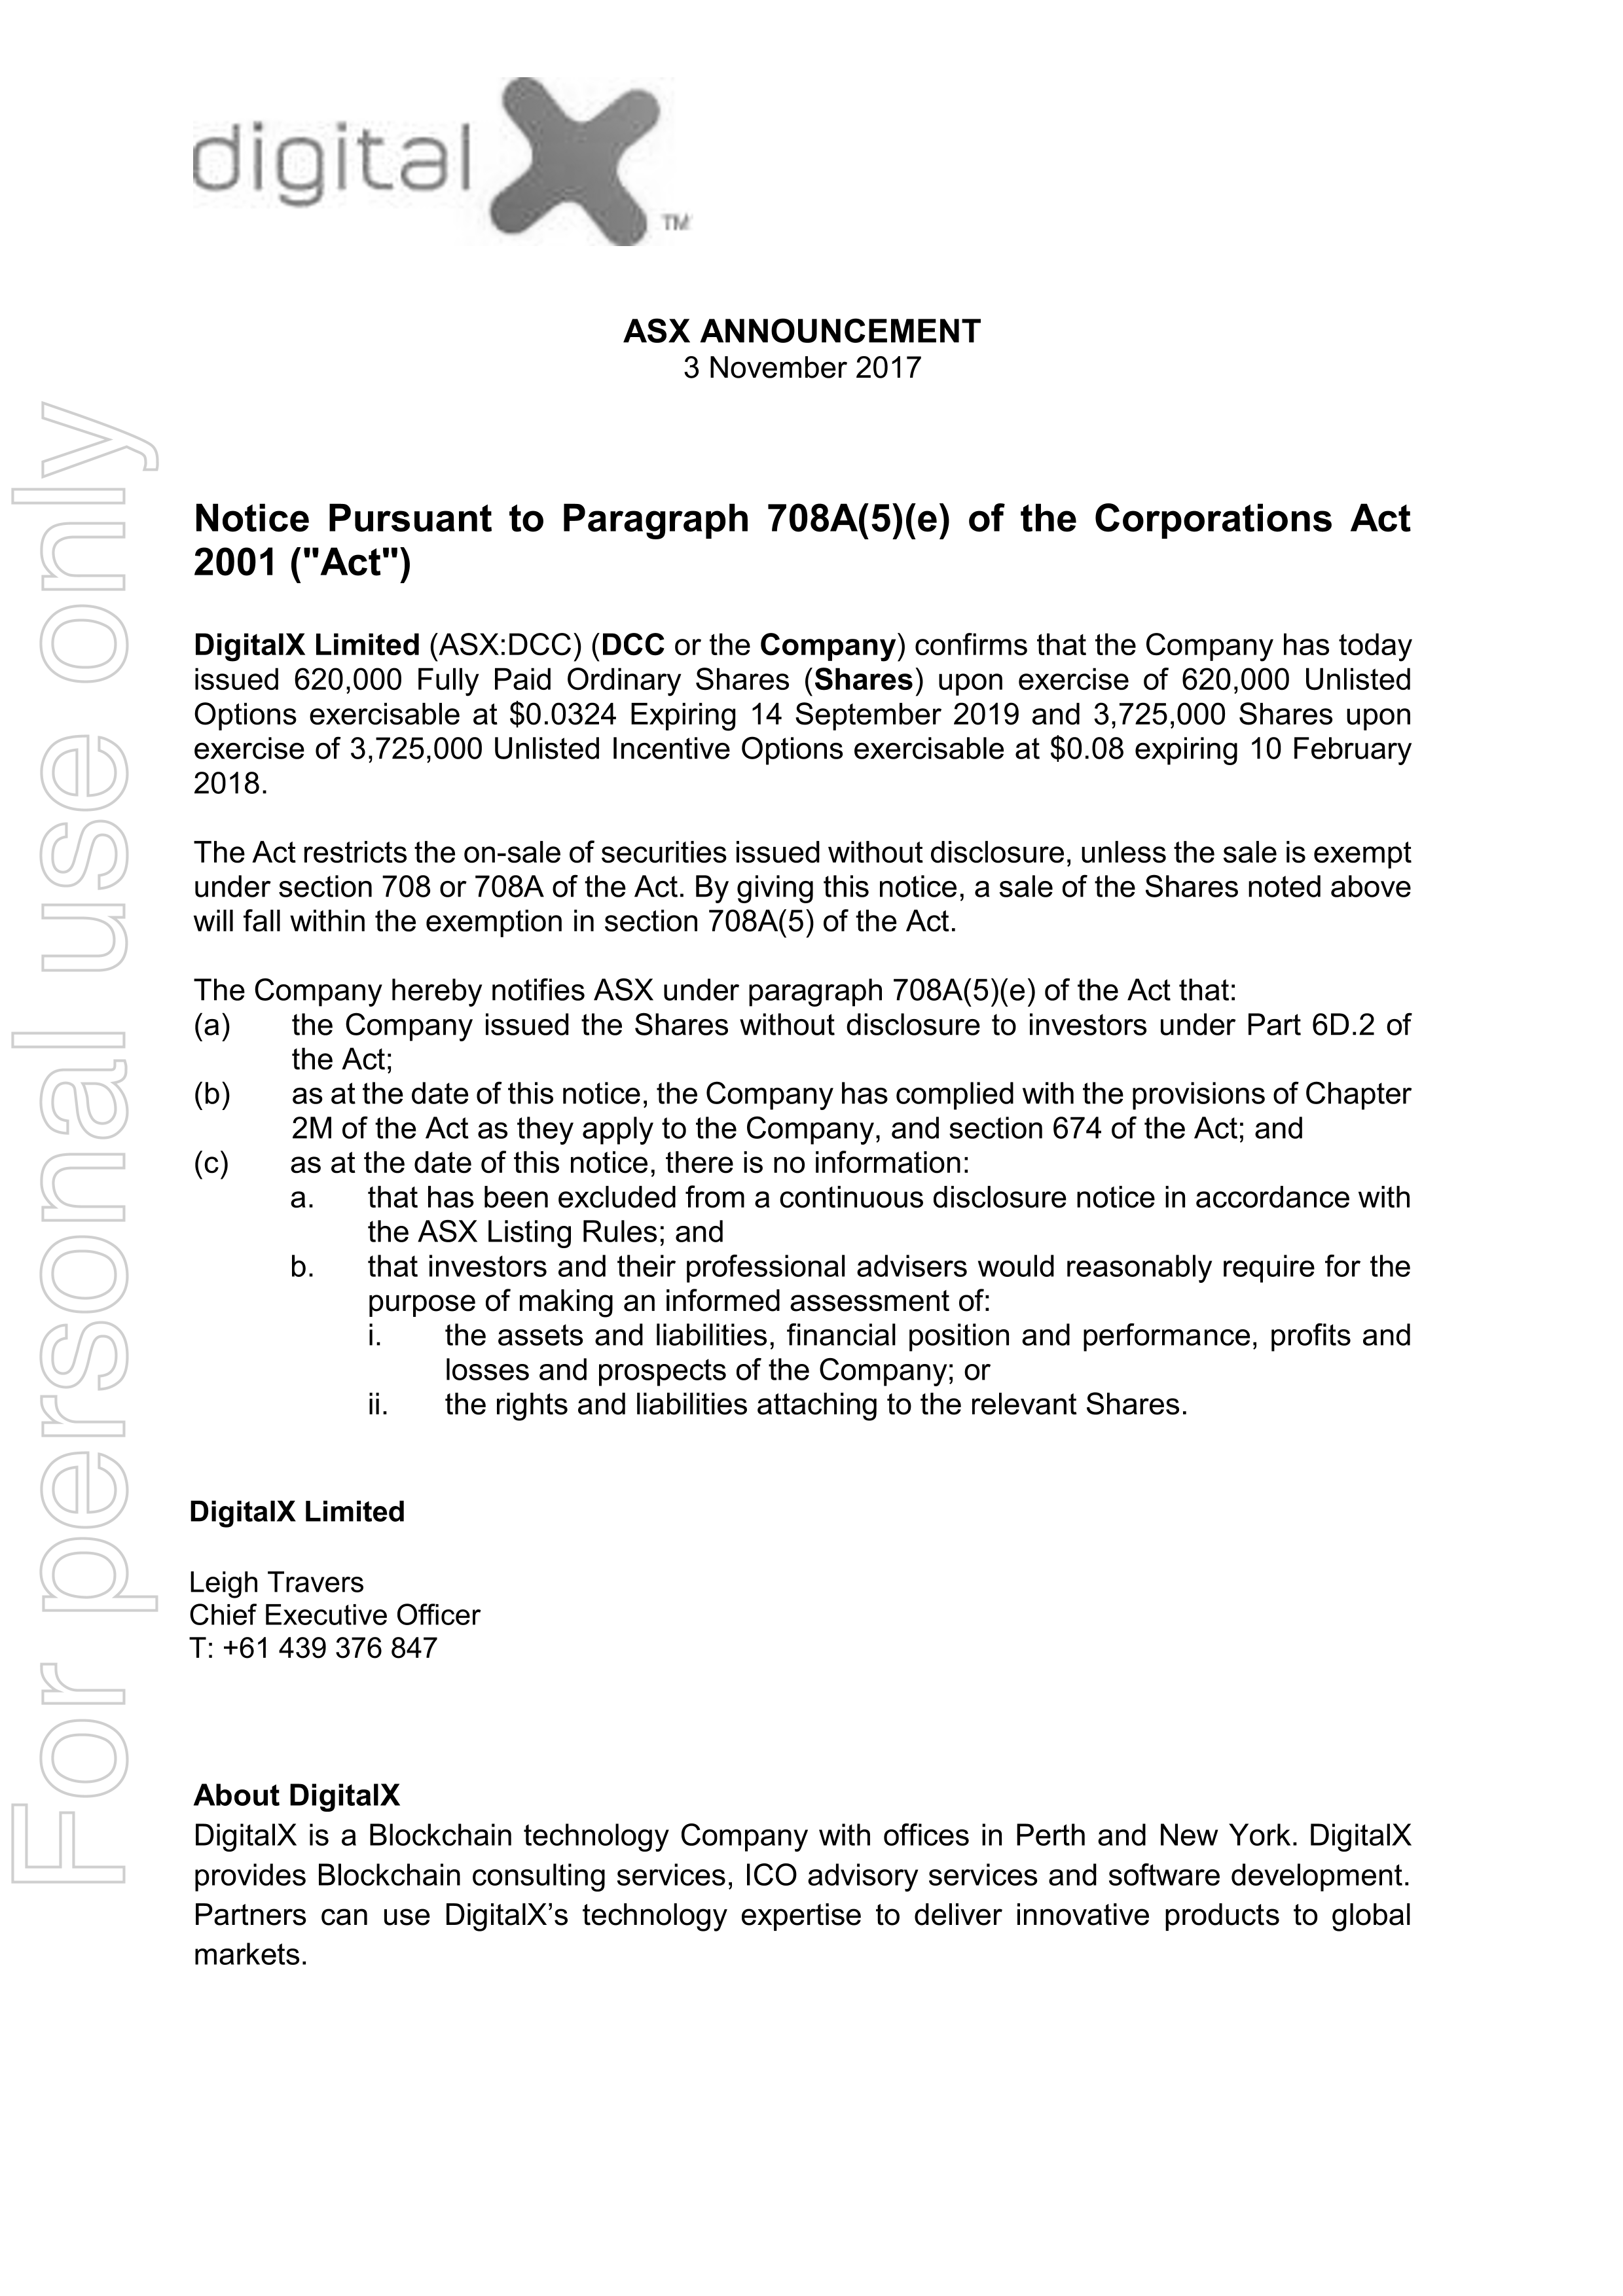

In [57]:
for r in result.select("path","image").distinct().collect():
    display_image(r.image)

## Display results

In [28]:
result.select("pagenum","text", "confidence").show()

+-------+--------------------+-----------------+
|pagenum|                text|       confidence|
+-------+--------------------+-----------------+
|      0|ASX ANNOUNCEMENT
...|91.96627892388238|
+-------+--------------------+-----------------+



### Display recognized text

In [29]:
print("\n".join([row.text for row in result.select("text").collect()]))

ASX ANNOUNCEMENT
3 November 2017

Notice Pursuant to Paragraph 708A(5)(e) of the Corporations Act
2001 ("Act")

DigitalX Limited (ASX:DCC) (DCC or the Company) confirms that the Company has today
issued 620,000 Fully Paid Ordinary Shares (Shares) upon exercise of 620,000 Unlisted
Options exercisable at $0.0324 Expiring 14 September 2019 and 3,725,000 Shares upon
exercise of 3,725,000 Unlisted Incentive Options exercisable at $0.08 expiring 10 February
2018.

The Act restricts the on-sale of securities issued without disclosure, unless the sale is exempt
under section 708 or 708A of the Act. By giving this notice, a sale of the Shares noted above
will fall within the exemption in section 708A(5) of the Act.

The Company hereby notifies ASX under paragraph 708A(5)(e) of the Act that:
(a) the Company issued the Shares without disclosure to investors under Part 6D.2 of
the Act;
(b) as at the date of this notice, the Company has complied with the provisions of Chapter
2M of the Act as they 

# Example with image
## Load image by url and create dataframe

In [44]:
url = "https://www.w3.org/WAI/images/easychecks/contrast-gray-white.png"
response = requests.get(url)
my_raw_data = response.content
pdf_content = io.BytesIO(my_raw_data)
pdf_example_df = spark.createDataFrame([("file1", bytearray(my_raw_data)),], ("path", "content"))
pdf_example_df.show()

+-----+--------------------+
| path|             content|
+-----+--------------------+
|file1|[89 50 4E 47 0D 0...|
+-----+--------------------+



## Define OCR transformers and pipeline

In [45]:
def pipeline():
    
    # Transforrm PDF document to images per page
    binary_to_image = BinaryToImage()
    binary_to_image.setInputCol("content")
    binary_to_image.setOutputCol("image")

    # Run tesseract OCR
    ocr = ImageToText()
    ocr.setInputCol("image")
    ocr.setOutputCol("text")
    ocr.setConfidenceThreshold(65)
    
    pipeline = PipelineModel(stages=[
        binary_to_image,
        ocr
    ])
    
    return pipeline

## Run OCR pipeline

In [46]:
result = pipeline().transform(pdf_example_df).cache()

## Display original image

Image:
        origin: file1 
        width: 301
        height: 127
        mode: 10


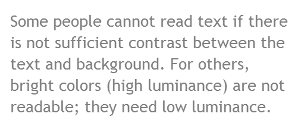

In [52]:
for r in result.select("path","image").distinct().collect():
    display_image(r.image)

## Display results

In [48]:
result.select("pagenum","text", "exception").show()

+-------+--------------------+---------+
|pagenum|                text|exception|
+-------+--------------------+---------+
|      0|Some people canno...|     null|
+-------+--------------------+---------+



In [49]:
print("\n".join([row.text for row in result.select("text").collect()]))

Some people cannot read text if there
is not sufficient contrast between the
text and background. For others,
bright colors (high luminance) are not
readable; they need low luminance.



## Clear cache

In [30]:
result.unpersist()

DataFrame[path: string, image: struct<origin:string,height:int,width:int,nChannels:int,mode:int,resolution:int,data:binary>, pagenum: int, confidence: double, positions: array<struct<mapping:array<struct<c:string,p:int,x:float,y:float,width:float,height:float,fontSize:int>>>>, exception: string, text: string]